In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from utils import *
from numpy.fft import fft2, ifft2, fftshift
from SALSA import SALSA
import pywt

In [2]:
img_ref = cv2.cvtColor( cv2.imread("images/cameraman.tif"), cv2.COLOR_BGR2GRAY)
M, N = img_ref.shape[:2]

In [3]:
# Blur kernel and operators

# uniform blur
h_1d = np.zeros(img_ref.shape[0],)
lh = 9
h_1d[:lh] = 1
h_1d = h_1d/h_1d.sum()
h_1d = cshift(h_1d,int(-(lh-1)/2) )
h_blur = np.outer(h_1d.transpose(), h_1d)

if 0:
    #Gaussian blur
    h_1d = np.zeros(img_ref.shape[0],)
    lh = 51
    h_1d[:lh] = np.divide( np.ones(lh,), (np.array( range(0,lh) )-((lh-1)/2.0) )**2+1 )
    h_1d = h_1d/h_1d.sum()
    h_1d = cshift(h_1d,int(-(lh-1)/2) )
    h_blur = np.outer(h_1d.transpose(), h_1d)

HF = fft2(h_blur)
HFC = np.matrix.conjugate(HF)

def A_op(x):
    YF = np.multiply(HF,fft2(x))
    #y = np.real( fftshift( ifft2(YF)) )
    y = np.real( ifft2(YF) )
    return y

def AT_op(x):
    YF = np.multiply(HF.conjugate(),fft2(x))
    #y = np.real( fftshift( ifft2(YF)) )
    y = np.real( ifft2(YF) )
    return y

In [4]:
SNRdb = 40
y = A_op( addGaussianNoise(img_ref, SNRdb) )

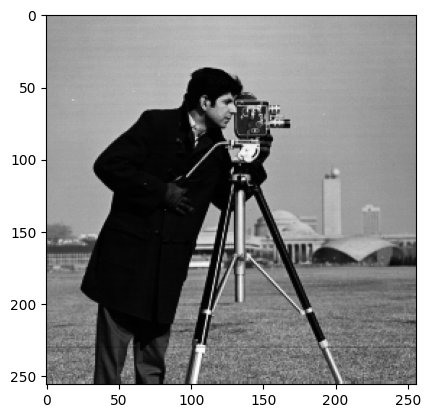

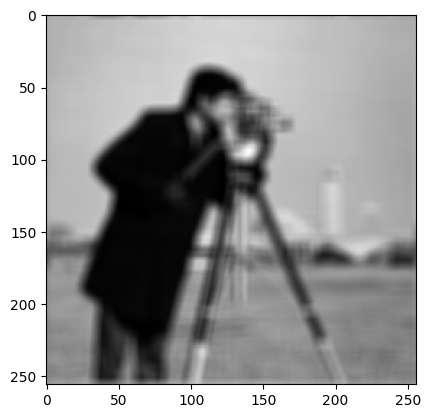

In [5]:
plt.figure(1)
plt.imshow(img_ref, cmap=plt.cm.gray)

plt.figure(2)
plt.imshow(y, cmap=plt.cm.gray)

In [6]:
num_levels = 3
wavelet_str = 'db2'

W = lambda x: wrapper_iswt2(x, wavelet_str, num_levels)
WT = lambda x: wrapper_swt2(x, wavelet_str, num_levels)

In [7]:
# parameters
lambda_reg = 0.0075
mu = 0.1*lambda_reg
muinv = 1/mu
outeriters = 150
tol = 1e-3

def invLS(x, mu):
    filter_FFT = np.multiply( np.divide( HF.conjugate(), (np.abs(HF)**2 + mu) ), HF)
    return( (1/mu)*( x - WT( np.real( ifft2( np.multiply( filter_FFT,fft2( W(x) ) ) ) ) ) ) )

A = lambda x: A_op( W(x) )
AT = lambda x: WT( AT_op(x) )

In [8]:
salsa_obj = SALSA( y, A, AT, invLS=invLS, tau=lambda_reg)

x, objective, times, distance, numA, numAt = salsa_obj.predict(y, tau=lambda_reg,mu =mu,\
                                                                     stopCriterion=1,\
                                                                     MaxIt=outeriters,\
                                                                     tolA=tol,\
                                                                     verbose=1)
x_out = W(x)
print ("ISNR is ",myISNR(img_ref,y,x_out ))

Initial value of objective function = 3.01e+06
iter= 0, obj= 1.09e+03, stop criterion= 1.00e+00, (target= 1.00e-03)
iter= 1, obj= 9.29e+05, stop criterion= 8.48e+02, (target= 1.00e-03)
iter= 2, obj= 8.76e+05, stop criterion= 5.64e-02, (target= 1.00e-03)
iter= 3, obj= 8.65e+05, stop criterion= 1.27e-02, (target= 1.00e-03)
iter= 4, obj= 8.57e+05, stop criterion= 9.30e-03, (target= 1.00e-03)
iter= 5, obj= 8.50e+05, stop criterion= 8.21e-03, (target= 1.00e-03)
iter= 6, obj= 8.43e+05, stop criterion= 7.69e-03, (target= 1.00e-03)
iter= 7, obj= 8.37e+05, stop criterion= 7.36e-03, (target= 1.00e-03)
iter= 8, obj= 8.31e+05, stop criterion= 7.11e-03, (target= 1.00e-03)
iter= 9, obj= 8.26e+05, stop criterion= 6.90e-03, (target= 1.00e-03)
iter= 10, obj= 8.20e+05, stop criterion= 6.73e-03, (target= 1.00e-03)
iter= 11, obj= 8.15e+05, stop criterion= 6.57e-03, (target= 1.00e-03)
iter= 12, obj= 8.09e+05, stop criterion= 6.44e-03, (target= 1.00e-03)
iter= 13, obj= 8.04e+05, stop criterion= 6.30e-03, (t

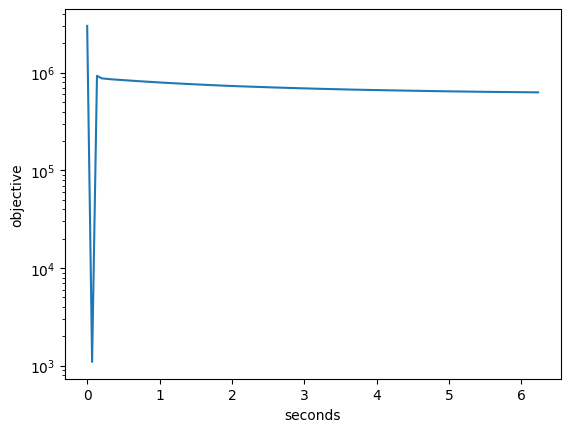

In [9]:
plt.semilogy(times,objective)
plt.xlabel('seconds')
plt.ylabel('objective')
plt.show()

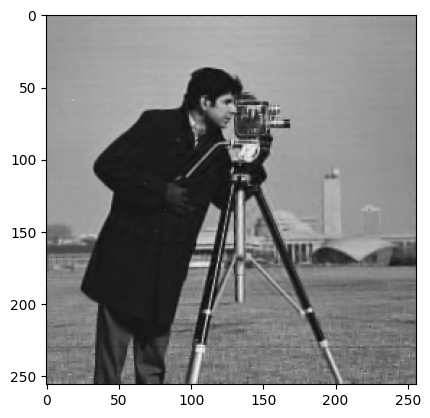

In [10]:
plt.imshow(x_out, cmap=plt.cm.gray)
plt.show()